In [137]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
from PIL import Image

# **PART 1 : Using OpenCV Canny**

In this part, I will just show what to expect of the canny edge detection that I will implement in part 2. 

Here, we just read the grayscale of our image and apply the *cv2.Canny* function to detect the edges. The arguments given to the function are the thresholds, **25=lower** threshold & **200 = upper** threshold. These vary from *0-255*. 

These thresholds need to be adapted for the image you want to process. If you have an image with thin edges, you want to lower the threshold to detect these thin edges. For images with more noise, a higher threshold is more adapted because it will reduce false positives. 

Let's begin ! 

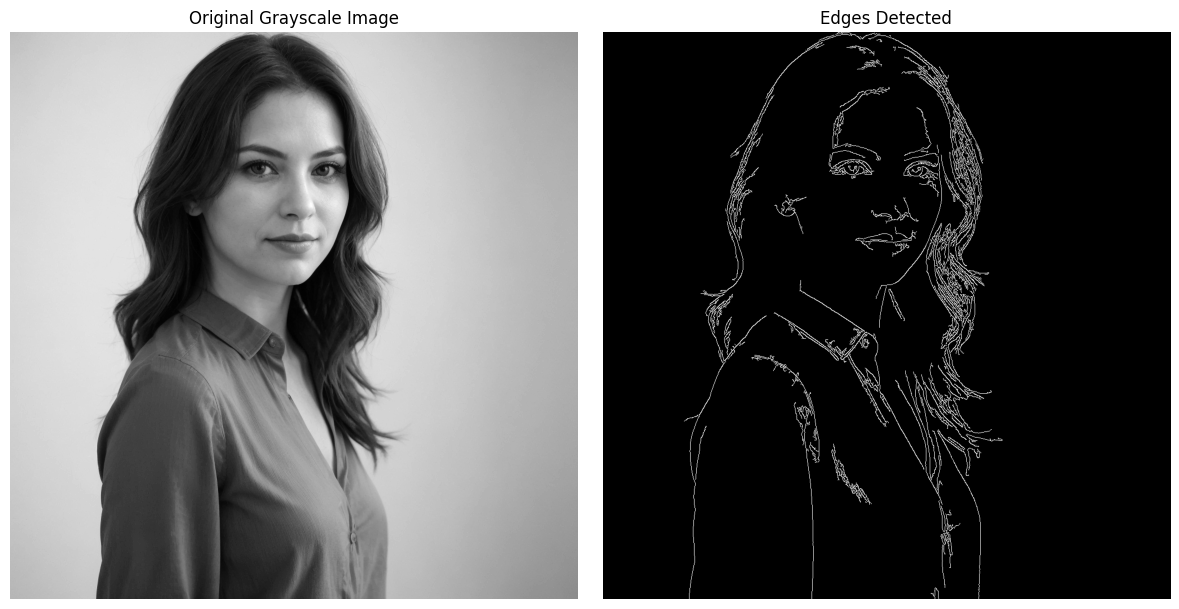

In [138]:
im=cv2.imread('woman.png', cv2.IMREAD_GRAYSCALE)
im_edge_cv=cv2.Canny(im,25,200)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

#original image displaying
axes[0].imshow(im, cmap='gray')
axes[0].set_title("Original Grayscale Image")
axes[0].axis('off')  
#blurred image using gaussian blur from openCV - dsiplaying
axes[1].imshow(im_edge_cv, cmap='gray')
axes[1].set_title("Edges Detected")
axes[1].axis('off')  

# Show the images
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# **PART 2 : Using NumPy**

The implementation of the Canny filter requires many steps, which are : 
- Grayscale Conversion (if not already).
- Gaussian Blur to reduce noise.
- Gradient Calculation using Sobel filters.
- Non-Maximum Suppression to thin edges.
- Double Threshold for edge linking.
- Edge Tracking by Hysteresis to finalize edge detection.

Thanks to the algorithms implemented before in my other projects (gaussian blur and sobel filter), the first three steps will be dealt with easily, and I will not be commenting on these algorithm and explaining how they work. If you wish to understand how the first three steps were implemented, please refer to my previous projects : 
- **00-Gaussian_Blur**
- 0**1-Sobel_Filter**

Let's begin !

### **STEP 1-2-3 : Implementing previous work**

Gradient magnitude range: 0.0 to 255.0


(-0.5, 1023.5, 1023.5, -0.5)

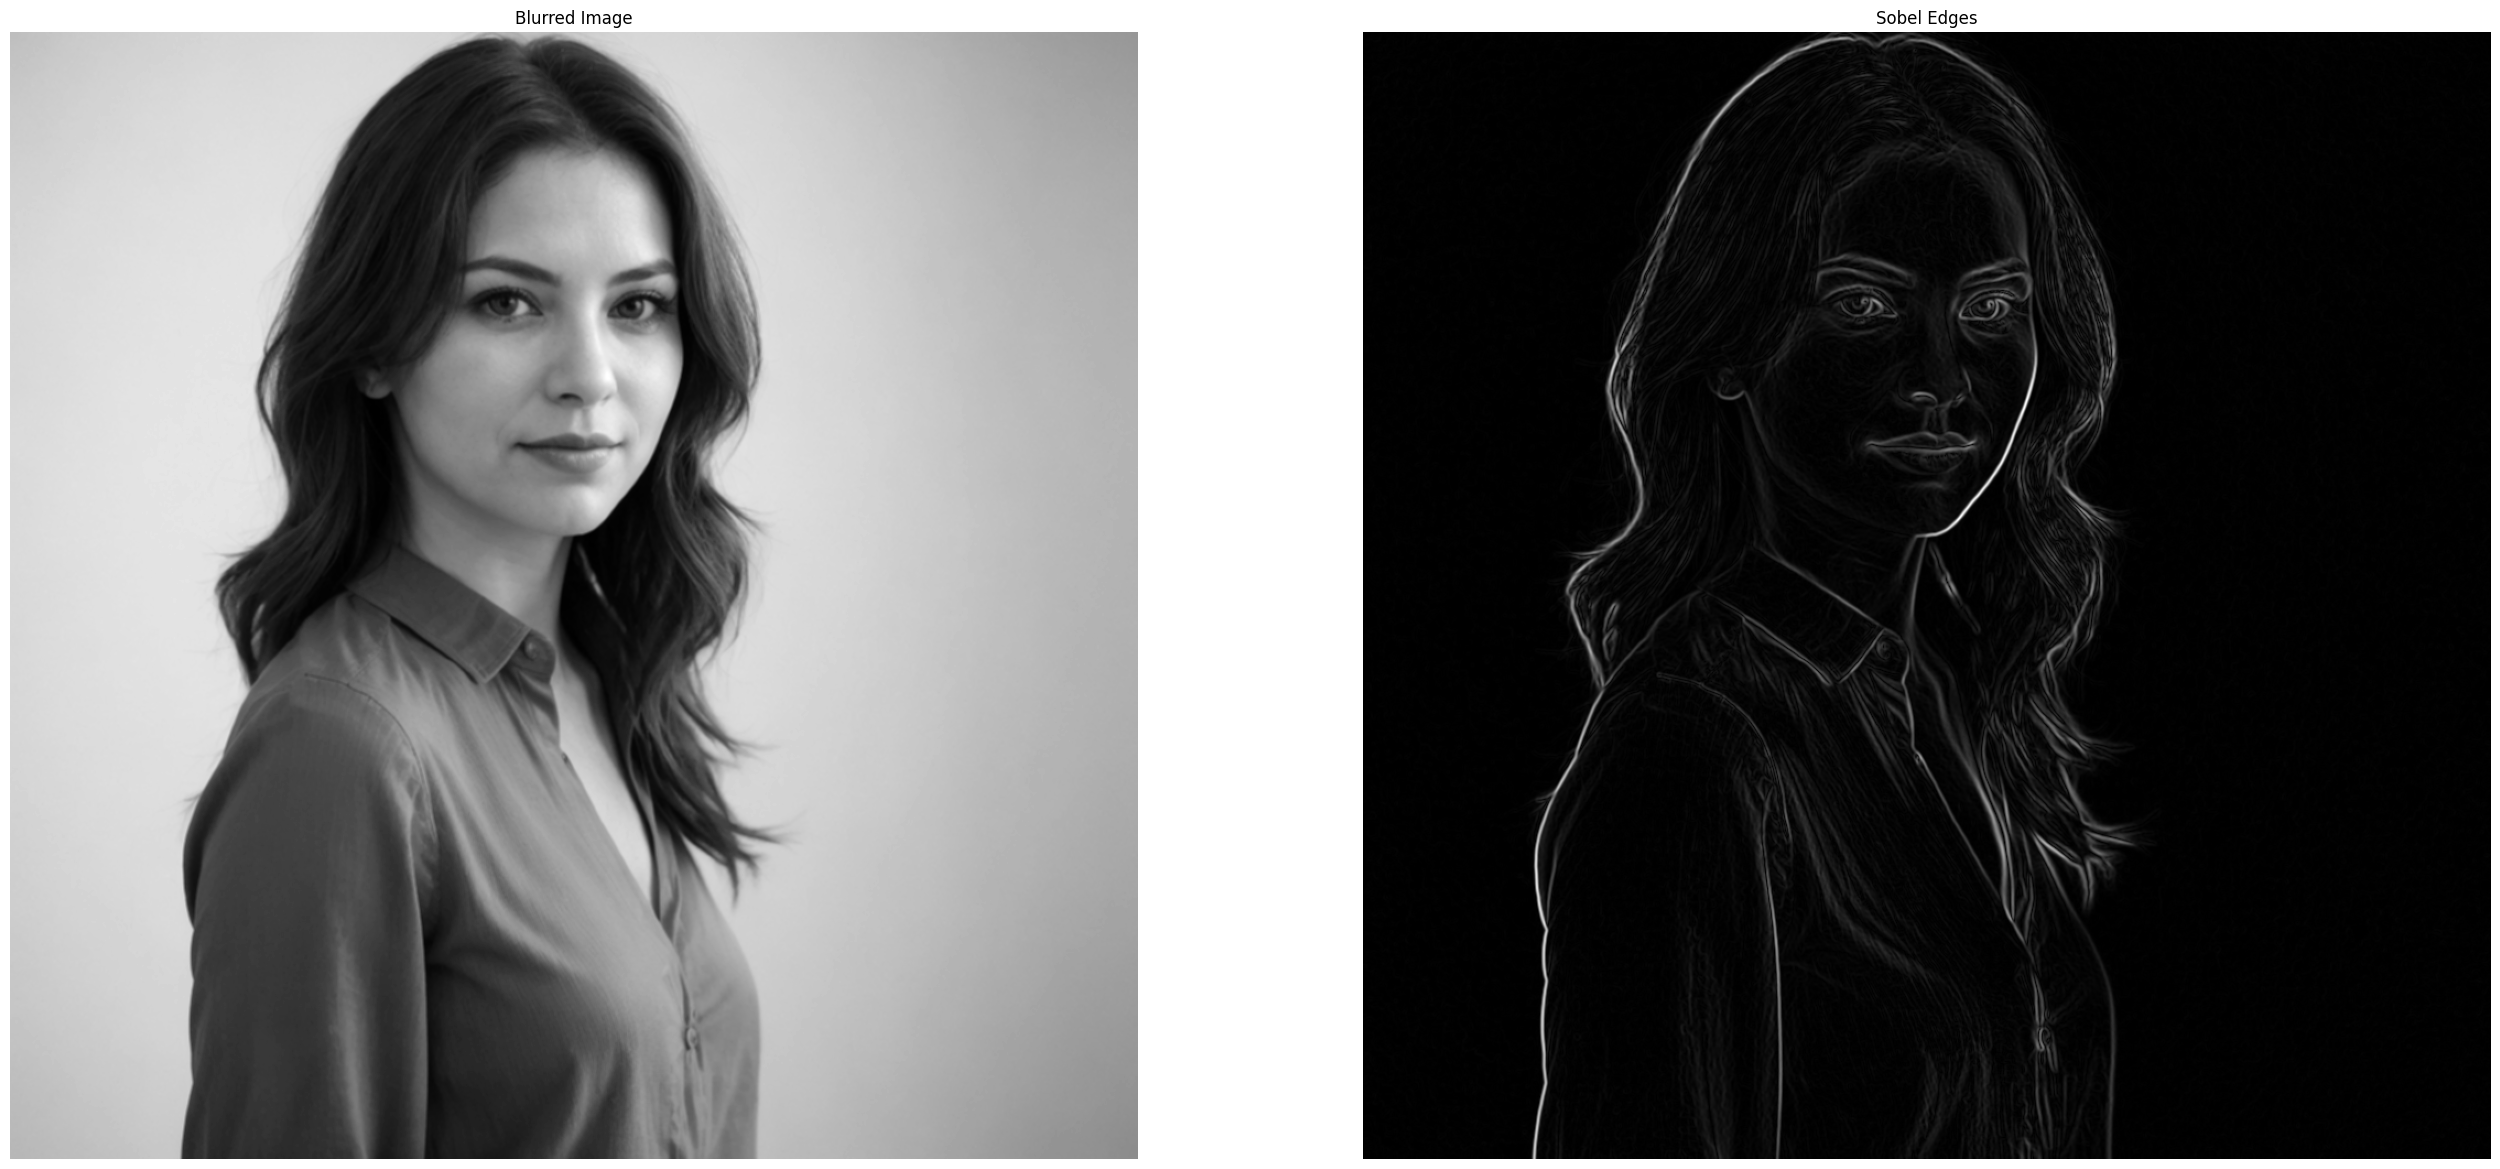

In [139]:
#defining the kernel creation function
def gaussian_kernel(size, sigma):
    ax = np.linspace(-(size // 2), size // 2, size)
    kernel_1d = np.exp(-0.5 * (ax / sigma)**2)
    kernel_2d = np.outer(kernel_1d, kernel_1d)
    kernel_normalized = kernel_2d / np.sum(kernel_2d)
    return ax, kernel_2d, kernel_normalized

def apply_gaussian_blur(image, kernel):
    if image.ndim == 3:  # Color image (3D array)
        return np.stack([convolve2d(image[:, :, c], kernel, mode='same', boundary='symm') for c in range(image.shape[2])], axis=2)
    else:  # Grayscale image (2D array)
        return convolve2d(image, kernel, mode='same', boundary='symm')
    
kernel_size = 3
sigma = 1.4

ax,kernelNN,kernel = gaussian_kernel(kernel_size, sigma)
blurred_image = apply_gaussian_blur(im, kernel)

sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

sobel_y = np.array([[-1, -2, -1],
                    [ 0,  0,  0],
                    [ 1,  2,  1]])

image_gray=blurred_image
padded_image = np.pad(image_gray, pad_width=1, mode='reflect')

grad_x = np.zeros_like(image_gray, dtype=np.float64)  #x direction
grad_y = np.zeros_like(image_gray, dtype=np.float64)  #y direction

for i in range(image_gray.shape[0]):
    for j in range(image_gray.shape[1]):
        region = padded_image[i:i+3, j:j+3]
        grad_x[i, j] = np.sum(region * sobel_x)
        grad_y[i, j] = np.sum(region * sobel_y)

grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
grad_x = grad_x * 2
grad_y = grad_y * 2
grad_magnitude = grad_magnitude / grad_magnitude.max() * 255

print(f"Gradient magnitude range: {grad_magnitude.min()} to {grad_magnitude.max()}")


fig, axes = plt.subplots(1, 2, figsize=(32, 16)) 

#original image displaying
axes[0].imshow(blurred_image, cmap='gray')
axes[0].set_title("Blurred Image")
axes[0].axis('off')  

axes[1].imshow(grad_magnitude, cmap='gray')
axes[1].set_title("Sobel Edges")
axes[1].axis('off')  

### **STEP 4 : Non maximus suppresion to make edges thinner**

This step can also be called *edge thinning*. See, on the picture above, the edges are thick and mutiple pixels show strong gradient magnitudes. The goal is make the edges thinner so that only the pixel with the strongest gradient magnitude is kept. Consequently for each pixel we will compare it with it's neighbors in the same direction. If the gradient magnitude is not the highest of the neighbors, we set it to 0 (black) in order to make the edges thinner.

**HOW DOES IT WORK?** We go through each pixel in the image (except boundary pixels) and get the direction of the gradient for the pixel and we identify the two neighbors that are along that same direction. The main pixel's gradient magnitude is compared to its neighboring pixels. As explained above, if the gradient magnitude of the pixel is the highest of its neighbors we keep it, otherwise we set it to 0. The output we will get at the end is an array containing only the "strongest" edges. 


There is a question I asked myself : **Why wouldn't I use padding to go through absolutely all the pixels in the image ?**
The answer is that if we do that, we might detect strong edges that are false positives at the boundaries. Remeber, there are no valid neighbor pixels outside the boundaries. Furthermore, most edges of interest in an image are inside the image rather than on the borders, hence why we can neglect it.



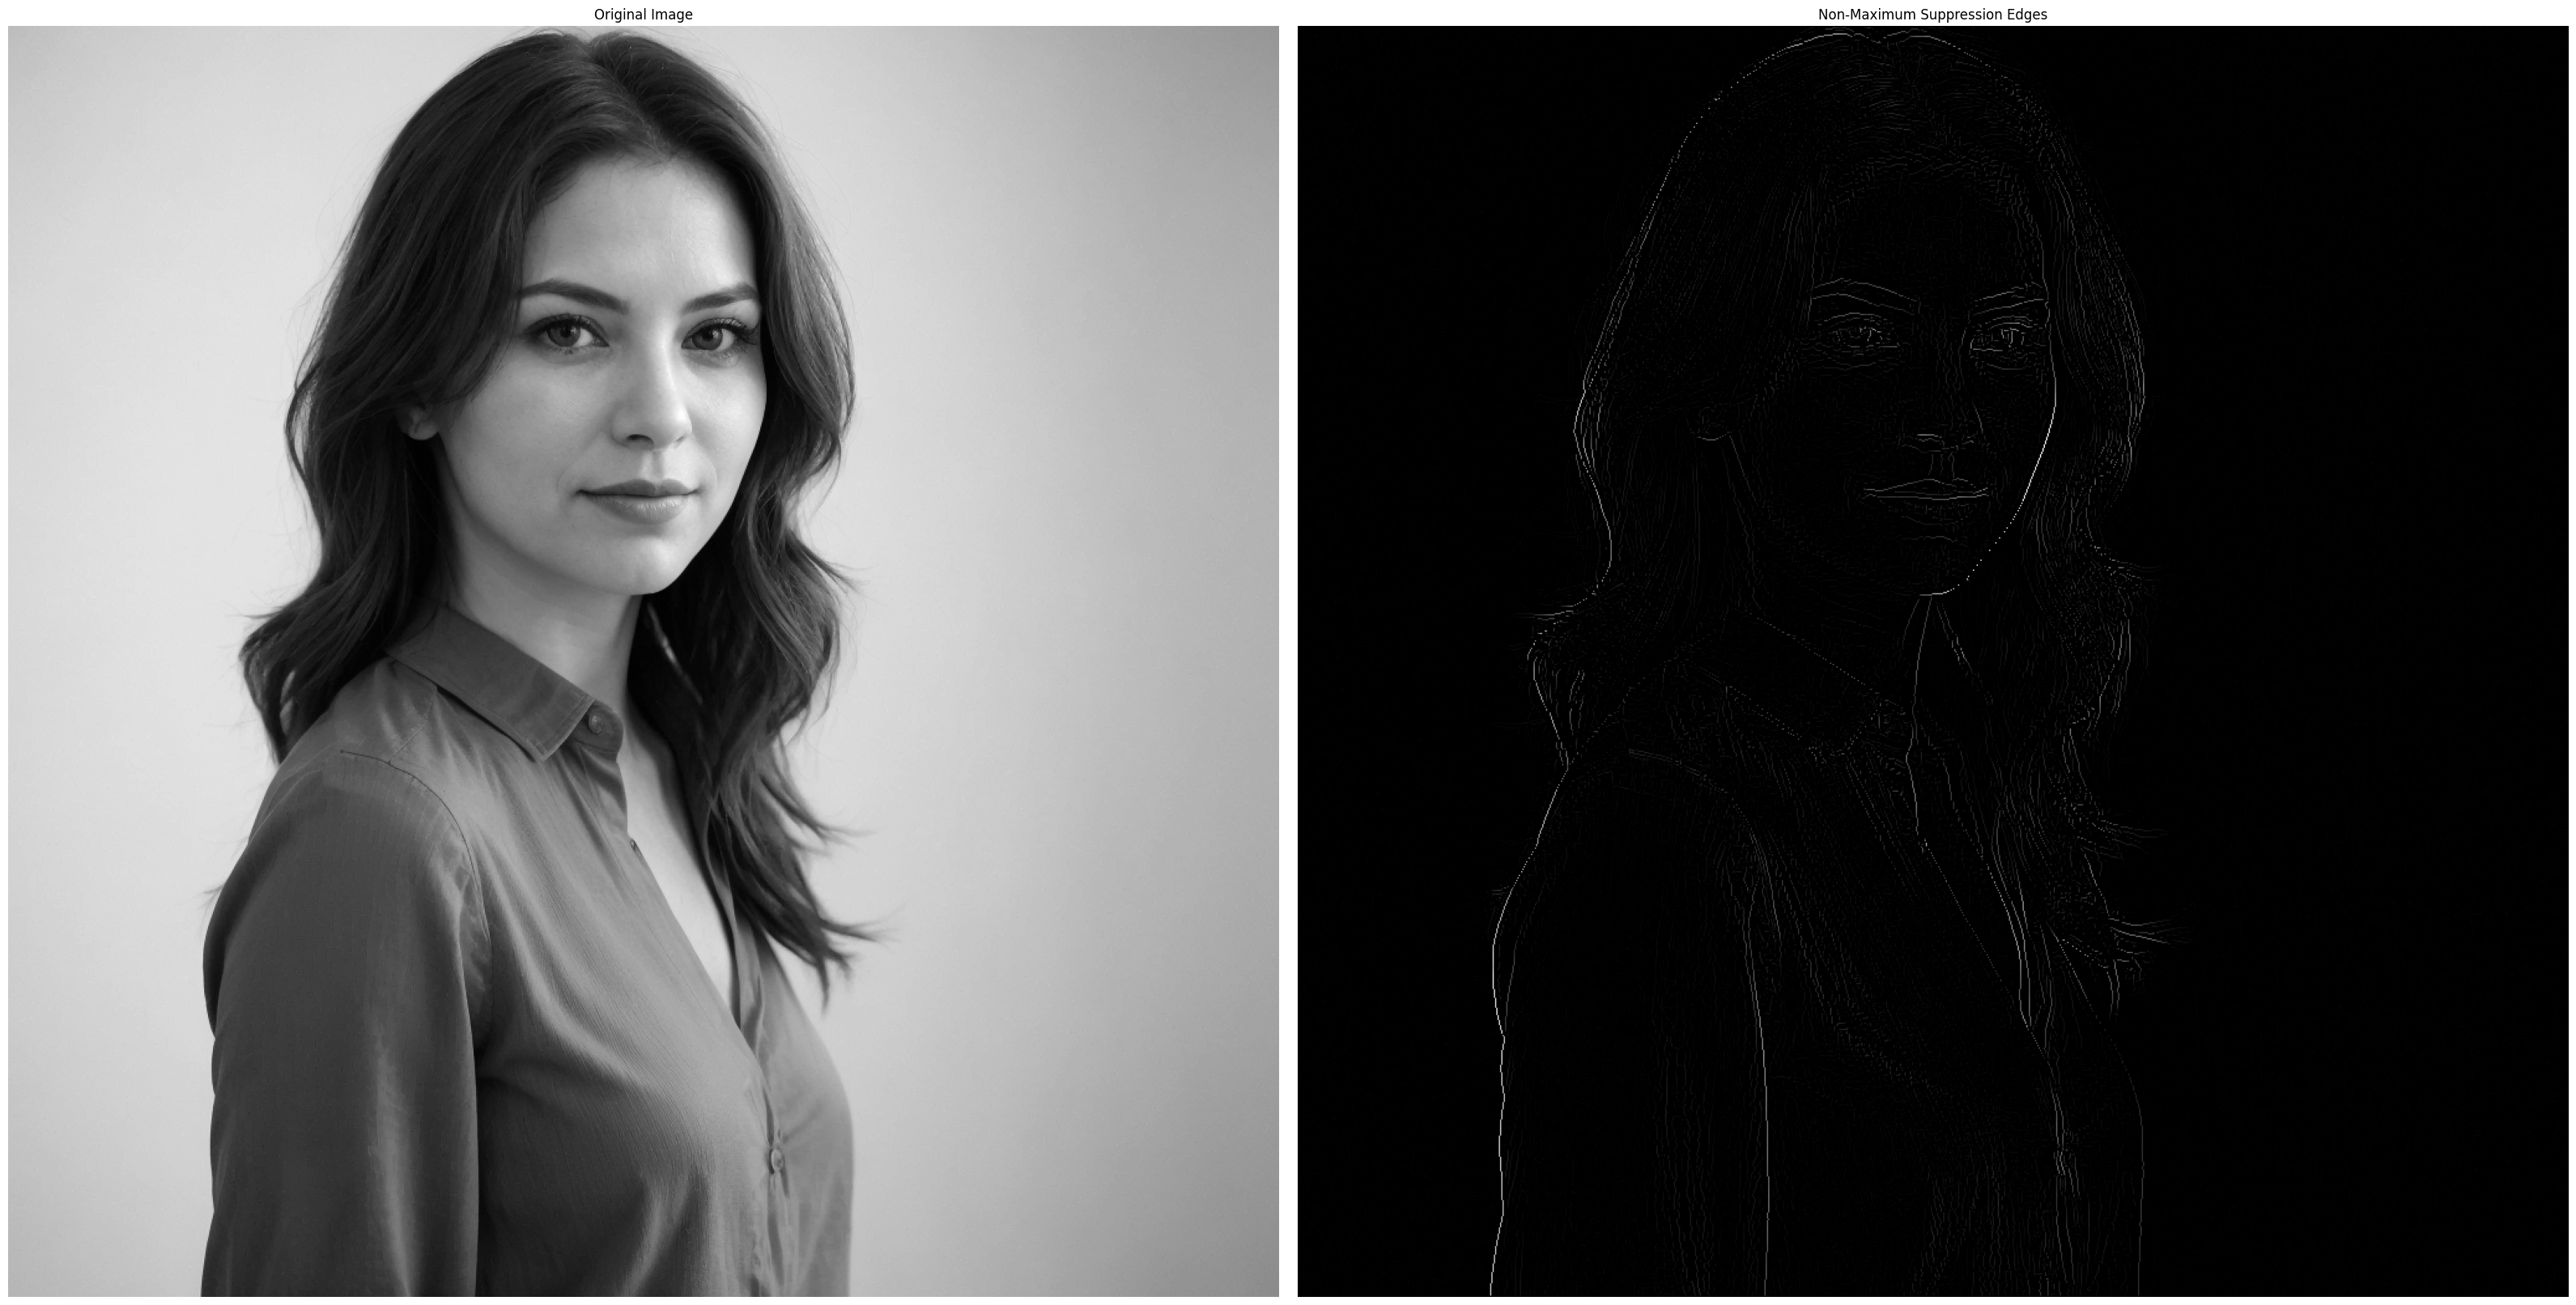

In [140]:
grad_direction = np.arctan2(grad_y, grad_x) * (180.0 / np.pi)  #getting the direction gradient magnitude matrix, converting to degrees to work easier

def non_maximum_suppression(gradient_magnitude, gradient_direction):
    rows, cols = gradient_magnitude.shape
    nms = np.zeros((rows, cols), dtype=np.float32)

    angle = gradient_direction % 180  #normalize to 180 degrees 

    for i in range(1, rows-1):
        for j in range(1, cols-1):
            try:
                direction = angle[i, j]

                if (0 <= direction < 22.5) or (157.5 <= direction <= 180):
                    before = gradient_magnitude[i, j - 1]  # Left
                    after = gradient_magnitude[i, j + 1]  # Right
                elif 22.5 <= direction < 67.5:
                    before = gradient_magnitude[i - 1, j + 1]  # Top-right
                    after = gradient_magnitude[i + 1, j - 1]  # Bottom-left
                elif 67.5 <= direction < 112.5:
                    before = gradient_magnitude[i - 1, j]  # Top
                    after = gradient_magnitude[i + 1, j]  # Bottom
                elif 112.5 <= direction < 157.5:
                    before = gradient_magnitude[i - 1, j - 1]  # Top-left
                    after = gradient_magnitude[i + 1, j + 1]  # Bottom-right

                if gradient_magnitude[i, j] >= before and gradient_magnitude[i, j] >= after:
                    nms[i, j] = gradient_magnitude[i, j]
                else:
                    nms[i, j] = 0

            except IndexError:
                pass

    return nms

nms_result = non_maximum_suppression(grad_magnitude, grad_direction)

fig, axes = plt.subplots(1, 2, figsize=(32, 16)) 

#original image displaying
axes[0].imshow(im, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')  

axes[1].imshow(nms_result, cmap='gray')
axes[1].set_title("Non-Maximum Suppression Edges")
axes[1].axis('off')

plt.tight_layout()
plt.show()



### **STEP 5 : Double Thresholding**

Great, we have our thin edges. As you can see on the image just above, the edges are too thin and there is a lot of noise, unwanted edges. The double thresholding will help classify all our edges into 2 categories : strong and weak edges. These will be fined like this : 

- ***Strong Edges***: Pixels that have a gradient magnitude higher than a certain decided threshold.
- ***Weak Edges***: Pixels that have a gradient magnitude in between the higher threshold and the lower threshold. 

These threshold are numbers between 0-255 (intensity of pixel). Strong edges are guaranteed to be part of the final detected edges. Weak edges will be a part of the detected edges only if they are attached to a strong edge (*Edge tracking by hysteresis*). 

*The code I wrote below is commented for your convenience so you can understand easily.*

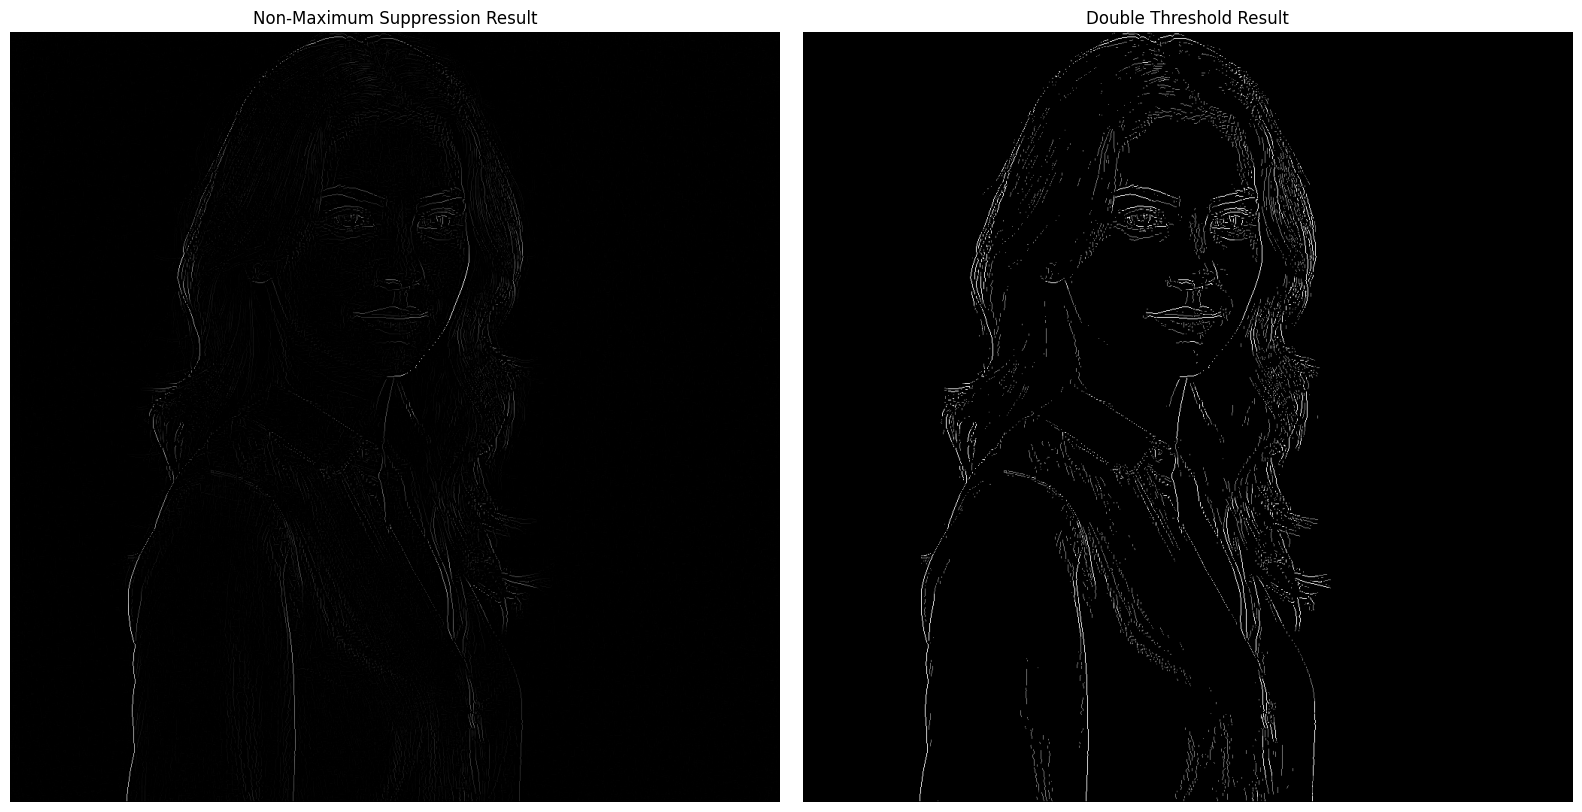

In [141]:
def double_thresholding(nms_image, low_thresh, high_thresh):
    #initializing output empty image 
    edges = np.zeros_like(nms_image, dtype=np.uint8)
    
    #classification of strong edges
    strong_pixels = nms_image > high_thresh
    edges[strong_pixels] = 255  #set color white for strong edges
    
    #classification of weak edges
    weak_pixels = (nms_image >= low_thresh) & (nms_image <= high_thresh)
    edges[weak_pixels] = 128  #set color gray to weak edges
    
    return edges

#decide of desired thresholds
low_thresh = 20
high_thresh = 45

#use function double_thresholding and display results
double_threshold_result = double_thresholding(nms_result, low_thresh, high_thresh)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(nms_result, cmap='gray')
axes[0].set_title("Non-Maximum Suppression Result")
axes[0].axis('off')

axes[1].imshow(double_threshold_result, cmap='gray')
axes[1].set_title("Double Threshold Result")
axes[1].axis('off')

plt.tight_layout()
plt.show()

### **STEP 6 : Edge tracking by hysteresis**

After the double threshold being applied, we have strong and weak edges remaining. As I explained earlier, the edge tracking by hysteresis will only keep the weak edges that are connected to strong edges. Of course, the strong edges from before are gueranteed so be in the resulting image. Unconnected weak edges will be removed. 

**HOW DOES THE ALGORITHM WORK ?** We go through all the weak edges in the image and we check the 8 surrounding neighbors of the pixel. If these were marked as strong edges, then we iterate until there are no more changes to make, and all pixels are either 255 or 0. Let's begin!




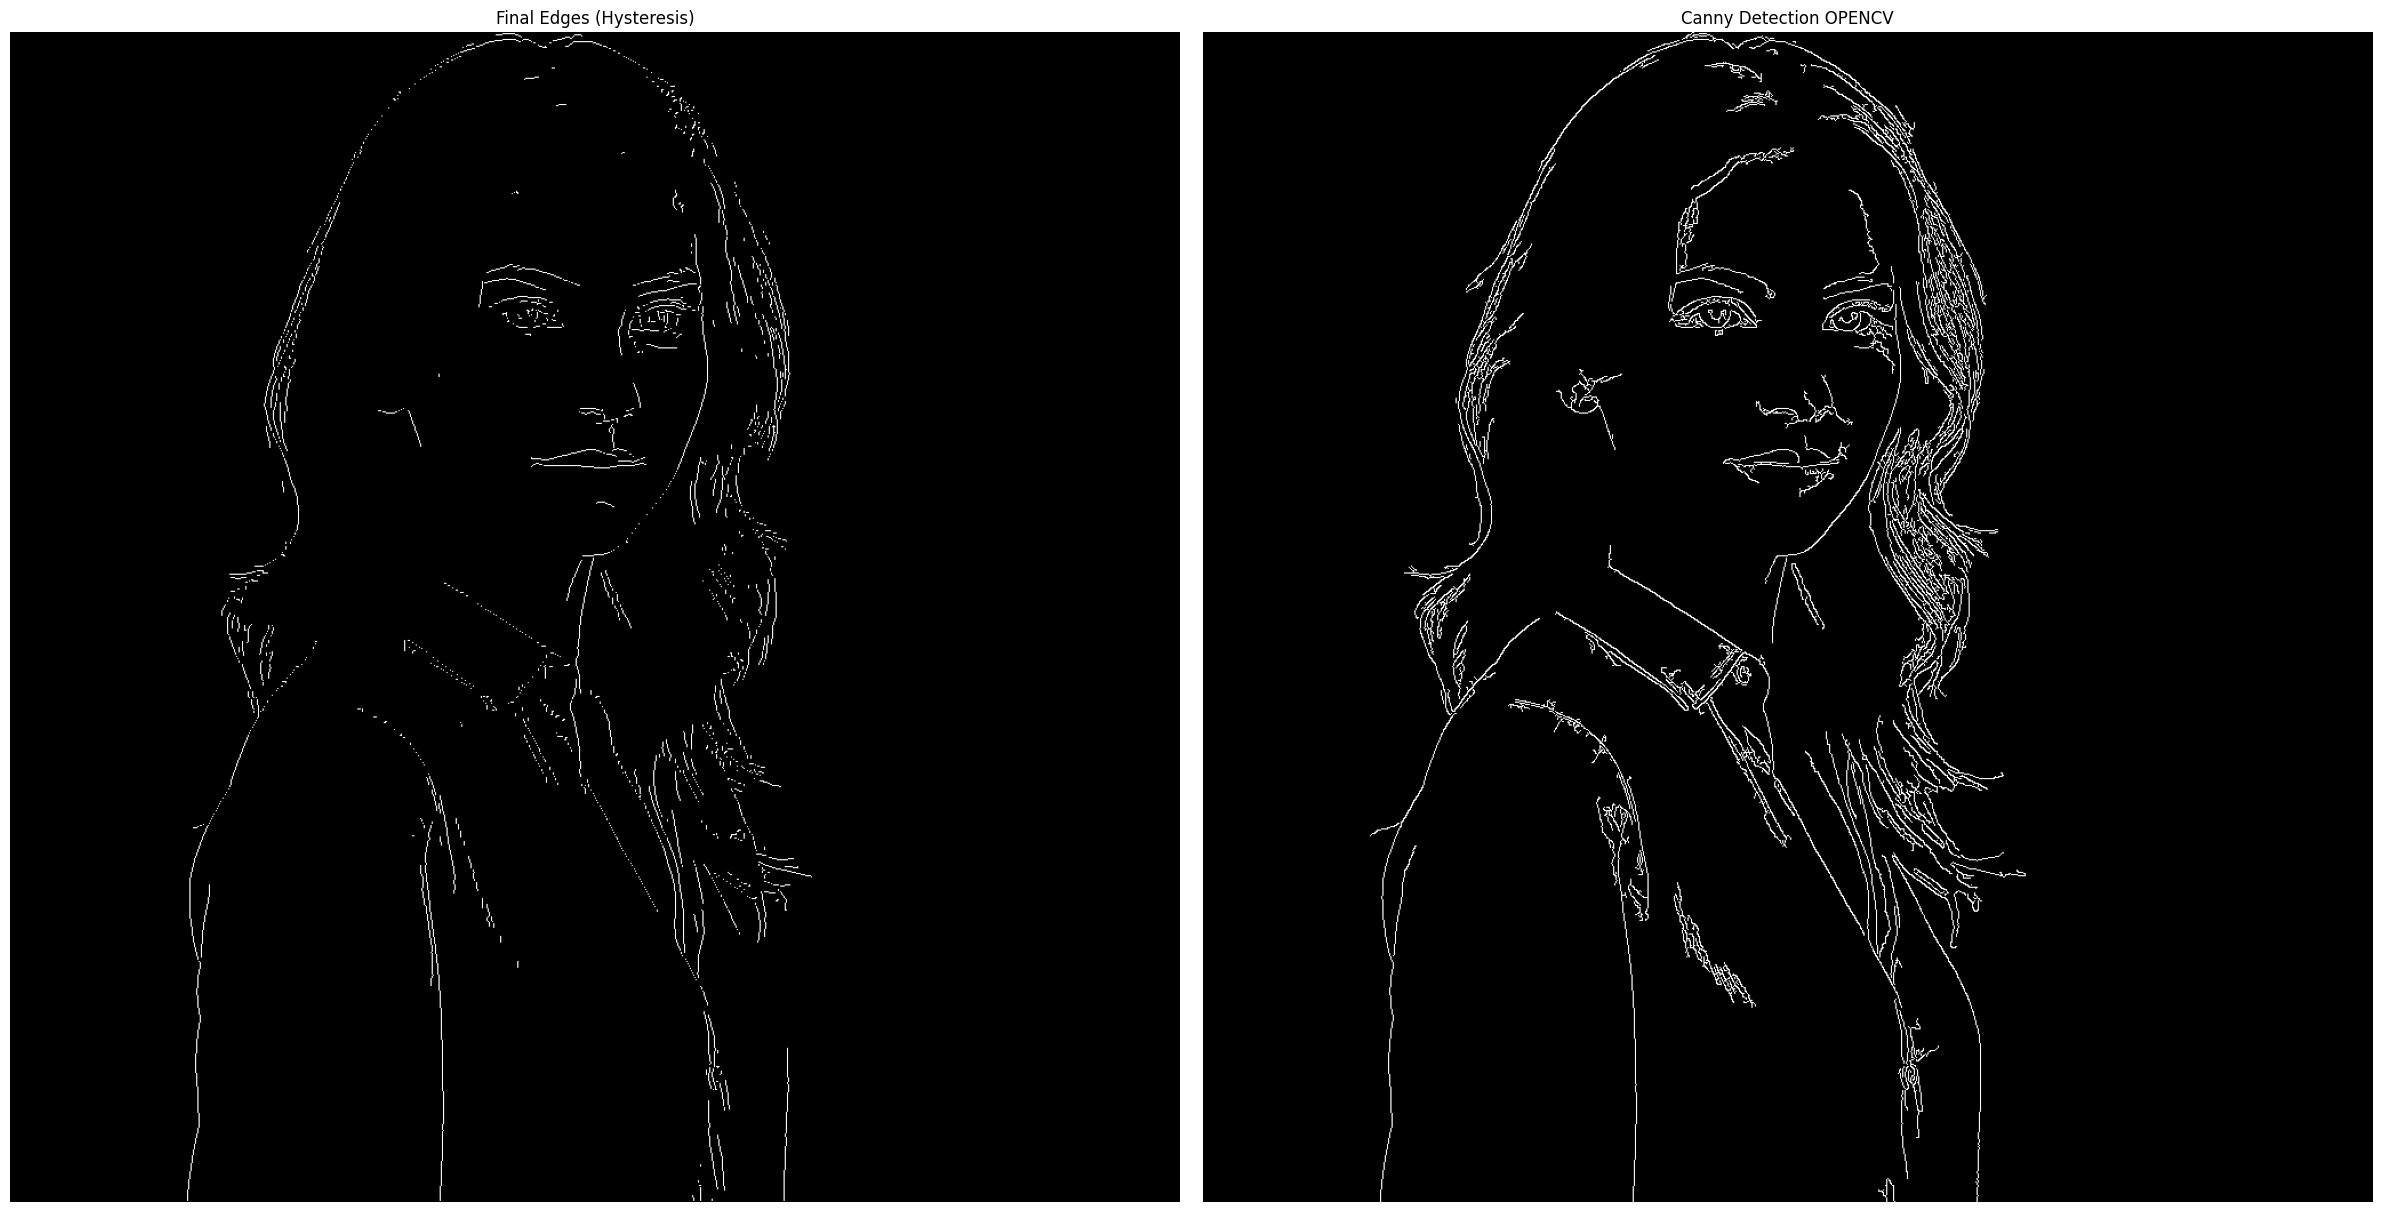

In [142]:
final_result=np.copy(double_threshold_result) #create a copy of the input image
rows, cols = final_result.shape

for i in range(1, rows-1):  #we don't go over the outer boundary pixel
        for j in range(1, cols-1):
            #check state of current pixel (weak/strong)
            if final_result[i, j] == 128:  #we detect a weak edge
                if (255 in final_result[i-1:i+2, j-1:j+2]):  #check neighboring pixels 3x3, if there is a strong pixel inside the neighbors
                    final_result[i, j] = 255  #weak edge becomes strong edge
                else:
                    final_result[i, j] = 0  #remove weak edge and set it to 0
    
#display the results
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

axes[0].imshow(final_result, cmap='gray')
axes[0].set_title("Final Edges (Hysteresis)")
axes[0].axis('off')

axes[1].imshow(im_edge_cv, cmap='gray')  # Show the original image for comparison
axes[1].set_title("Canny Detection OPENCV")
axes[1].axis('off')

plt.tight_layout()
plt.show()


### CONCLUSION 

I adapted the thresholds so that so result actually looks like something. But 
if I keep the thresholds 25-200, I wouldn't get an actual good output. Inside the Canny from openCV, we do not know which kernel size they use, nor the value of the sigma. 


I tried looking for an answer, but no chance. I can only play around with the variables. One other thing I thought about is amplifying the gradient magnitude to reveal even more the strong edges. 

If you want to discuss about the work, if you have any remarks, please contact me : remifourcroy.pro@gmail.com